In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import scipy.stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import os
#graph parameters (formatting)
plt.rcParams.update({'font.size': 22})
plt.rcParams["figure.figsize"] = (10,5)


In [2]:
#color formatting 
poster_colors = ['#0097A7','#B2EBF2','#00BCD4','#FF4081','#212121','#757575','#BDBDBD']
poster_palette_dict = {'dark_primary':'#0097A7','light_primary':'#B2EBF2','primary':'#00BCD4','icons':'#FFFFFF','accent':'#FF4081','primary_text':'#212121','secondary_text':'#757575','divider':'#BDBDBD'}
bright_colors = poster_colors

##graph colors for DTN and LMN hit and miss
c_dict = {'LMN_hit':poster_palette_dict['dark_primary'],'LMN_miss':poster_palette_dict['divider'],
         'LMN_adjacent':poster_palette_dict['secondary_text'],'DTN_hit':poster_palette_dict['accent'],
         'DTN_miss':poster_palette_dict['divider'],'DTN_adjacent':poster_palette_dict['secondary_text']}



def create_color_dict(column,color_ops=bright_colors):
    color_ops = bright_colors
    value_ops = list(df[column].unique())
    c_dict = {value_ops[i]:color_ops[i] for i in range(len(value_ops))}
    return c_dict



def color_map(df,column,color_ops=bright_colors):
    
    c_dict = create_color_dict(column)
    def color(row): 
        return c_dict[row[column]]
    df['color'] = df.apply(color, axis=1)
    return df,c_dict


In [3]:
#list of which fluorophore ctb was injected where (alternated injecting ctb 488(GFP) and 597(TXRED) in DTN)
DTN_fluorophore = pd.read_csv('DTN_fluorophore_with_old.csv')
DTN_fluorophore['brain'] = DTN_fluorophore['Brain']
DTN_fluorophore = DTN_fluorophore[['brain','DTN_fluorophore']]

#LMN_ctb_area_csv: contains measures of the area of ctb in LMN
LMN_ctb_area = pd.read_csv('lmn_ctb_total_injection_area.csv')
LMN_ctb_area['brain'] = LMN_ctb_area['Brain']

#SGN and DTN counts: Here, contra refers to contralateral to the DTN injection hemisphere and ipsi refers to ipsilateral to the DTN injection hemisphere
SGN_contra_counts = pd.read_csv('SGN_contra_counts_with_old.csv')
SGN_ipsi_counts = pd.read_csv('SGN_ipsi_counts.csv')
DTN_contra_counts = pd.read_csv('DTN_contra_counts.csv')
#make it easier to access all cell count csvs
df_list = [SGN_contra_counts, SGN_ipsi_counts, DTN_contra_counts]

#csv with a list of 'hit' and 'miss' classifications for LMN and DTN injections.  See paper for what was considered a hit and miss for each area.
injection_groups = pd.read_csv('hit_miss_group_paper.csv')


In [4]:
#Get which colors correspond to a DTN injection or LMN injection
#Those involved in cell counting were blind to which ctb color corresponded to DTN/LMN injection so original columns reported how many cells were visible in the 'GFP' channel and how many were visible in Texas Red 'TXRED'.  Need to convert colored cell counts from green and red to 'to DTN' and 'to LMN' based on record of where each ctb color was injected
#for each separate csv with grayscale count data:
for df in df_list:
    #just get a loc called 'to_DTN' are cells where fluorophores match DTN_fluorophore (df.loc brain is in DTN red, TXRED gets copied to to_DTN 
    to_DTN_red = DTN_fluorophore.loc[DTN_fluorophore['DTN_fluorophore']=='TXRED']
    to_DTN_green = DTN_fluorophore.loc[DTN_fluorophore['DTN_fluorophore']=='GFP']
    #the resulting dfs should contain the list of brains corresponding to the fluorophore injected in DTN.
    #i.e. the to_DTN_red DataFrame should have a list of all the brains where red ctb was injected.  
    
    df['to_DTN_red'] = df['brain'].isin(to_DTN_red['brain'])
    df['to_DTN_green'] = df['brain'].isin(to_DTN_green['brain'])
    
    #create empty columns to populate with count data
    df['to_DTN']=np.nan
    df['to_LMN']=np.nan

    #populate 'to_DTN' and 'to_LMN' columns with cell counts, separately adding the cells counted in the 'GFP' and 'TXRED' channels.
    df['to_DTN'] = df['to_DTN'].mask(df['to_DTN_red'] == True,df['TXRED'])

    df['to_DTN'] = df['to_DTN'].mask(df['to_DTN_red'] == False,df['GFP'])

    df['to_LMN'] = df['to_LMN'].mask(df['to_DTN_red'] == False,df['TXRED'])

    df['to_LMN'] = df['to_LMN'].mask(df['to_DTN_red'] == True,df['GFP'])
    

In [5]:
#get AP axis label numbers for groups
#change slide index numbers into percent axis......
#adding 0.0000001 to avoid divide by zero errors
for df in df_list:
    df['percent_axis_converted'] = 0.00001
    for brain in df['brain'].unique():   
        df['percent_axis_converted'].loc[df['brain']==brain] = (df['percent_axis']*(100/len(df['brain'].loc[df['brain']==brain])+ 0.000001))
        


C:\Users\F004b3k\AppData\Local\Temp\ipykernel_2624\548228648.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['percent_axis_converted'].loc[df['brain']==brain] = (df['percent_axis']*(100/len(df['brain'].loc[df['brain']==brain])+ 0.000001))
C:\Users\F004b3k\AppData\Local\Temp\ipykernel_2624\548228648.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['percent_axis_converted'].loc[df['brain']==brain] = (df['percent_axis']*(100/len(df['brain'].loc[df['brain']==brain])+ 0.000001))
C:\Users\F004b3k\AppData\Local\Temp\ipykernel_2624\548228648.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [6]:
#subgroups of the injection_group df.  Can analyze based on whether SGN_contra or SGN_ipsi is in these groups
#These are just names for filtered datasets based on whether an injection in DTN or LMN was a hit or a miss (e.g. DTN_hit)
#or whether both DTN and LMN were successful injections in the same animal. 
double_hit = injection_groups.loc[injection_groups['group'].str.contains('double_hit')]
DTN_hit = injection_groups.loc[injection_groups['group'].str.contains('DTN_hit')]
LMN_hit = injection_groups.loc[injection_groups['group'].str.contains('LMN_hit')]
DTN_miss = injection_groups.loc[injection_groups['group'].str.contains('DTN_miss')]
LMN_miss = injection_groups.loc[injection_groups['group'].str.contains('LMN_miss')]
DTN_adjacent = injection_groups.loc[injection_groups['group'].str.contains('DTN_adjacent')]
LMN_adjacent = injection_groups.loc[injection_groups['group'].str.contains('LMN_adjacent')]

#subgroups of adjacent (DTN_dorsal,medial,ventral,caudal) or LMN(dorsal, medial)
#filtered data based on WHERE ctb spread outside of DTN.
DTN_adjacent_dorsal = injection_groups.loc[ (injection_groups['DTN surround location'].isnull()==False) & (injection_groups['DTN surround location'].str.contains('dorsal')) & injection_groups['group'].str.contains('DTN_adjacent')]
DTN_adjacent_caudal = injection_groups.loc[(injection_groups['DTN surround location'].isnull()==False) &  (injection_groups['DTN surround location'].str.contains('caudal'))& injection_groups['group'].str.contains('DTN_adjacent')]
DTN_adjacent_medial = injection_groups.loc[(injection_groups['DTN surround location'].isnull()==False) & (injection_groups['DTN surround location'].str.contains('medial'))& injection_groups['group'].str.contains('DTN_adjacent')]
DTN_adjacent_ventral = injection_groups.loc[(injection_groups['DTN surround location'].isnull()==False) & (injection_groups['DTN surround location'].str.contains('ventral'))& injection_groups['group'].str.contains('DTN_adjacent')]
DTN_adjacent_ventricle = injection_groups.loc[(injection_groups['DTN surround location'].isnull()==False) & (injection_groups['DTN surround location'].str.contains('ventricle'))& injection_groups['group'].str.contains('DTN_adjacent')]
DTN_adjacent_lateral = injection_groups.loc[(injection_groups['DTN surround location'].isnull()==False) & (injection_groups['DTN surround location'].str.contains('lateral'))& injection_groups['group'].str.contains('DTN_adjacent')]

#and for LMN
LMN_adjacent_dorsal = injection_groups.loc[(injection_groups['LMN surround location'].isnull()==False) &  (injection_groups['LMN surround location'].str.contains('dorsal'))& injection_groups['group'].str.contains('LMN_adjacent')]
LMN_adjacent_medial = injection_groups.loc[(injection_groups['LMN surround location'].isnull()==False) & (injection_groups['LMN surround location'].str.contains('medial'))& injection_groups['group'].str.contains('LMN_adjacent')]
LMN_adjacent_injection_track = injection_groups.loc[(injection_groups['LMN surround location'].isnull()==False) & (injection_groups['LMN surround location'].str.contains('injection_track'))& injection_groups['group'].str.contains('LMN_adjacent')]

#If we need to make graphs based on multiple filtered datasets, makes it easier to access.
subgroup_list = [double_hit,DTN_hit ,LMN_adjacent_dorsal,LMN_adjacent_medial,DTN_adjacent_ventral, LMN_adjacent_injection_track,DTN_adjacent_ventricle,LMN_hit,DTN_miss,LMN_miss,DTN_adjacent_dorsal,DTN_adjacent_caudal,DTN_adjacent_medial]



In [7]:
#from the separate csvs containing cell counts (SGN_contra_counts, SGN_ipsi_counts, and DTN_contracounts), 
#extract the average and total cell counts for each brain. 
#add a column to injection_groups that has the sum of SGN cells to hit_miss table
#make areas and injection locations iterable
area_list = ['SGN','DTN']
hemisphere = ['ipsi','contra']
inj_loc = ['to_DTN','to_LMN','Double_label']
stat_list = ['total_count','avg_count']
#using the following to call the appropriate df in the for loop.  If the number of dfs gets unwieldly, need to use a for_loop generated dictionary for efficiency/memory
SGN_contra_identifier = 'SGN_contra'
SGN_ipsi_identifier = 'SGN_ipsi'

#loop through areas/hemisphers/inj_loc/stat_list and add a new column to hit_miss for each combination 
#note: hemisphere (['ipsi','contra']) refers to whether the hemisphere is ipsilateral or contralateral to the DTN injection.
for area in area_list:
    for side in hemisphere:
        if area == 'SGN' and side == 'contra':
            df = SGN_contra_counts
        elif area == 'SGN' and side == 'ipsi': 
            df = SGN_ipsi_counts
        else:
            df = DTN_contra_counts
        for loc in inj_loc:
            for stat in stat_list:
                injection_groups[area + '_' + side + '_' + loc + '_' + stat] = np.NaN
       
        #now get sums and averages for every combination and add to mask of injection_groups
            for brain in injection_groups['Brain']:
                #get a mask (injection_groups) and locator (slice_counts_dfs) so you can replace the counts and average with each area with appropriate sum and average for later graphing
                mask = injection_groups['Brain']== brain
                brain_loc = df[loc].loc[df['brain']==brain]
                
                injection_groups.loc[mask,area + '_' + side + '_' + loc + '_' + 'total_count'] = brain_loc.sum()
                injection_groups.loc[mask,area + '_' + side + '_' + loc + '_' + 'avg_count'] = brain_loc.sum()/(len(brain_loc)+.000001)
#add two new columns that give you the sum and average double label divided by the sum and average to_LMN/to_DTN
        
        #avg_counts,
        injection_groups[area +'_' + side+ '_avg_count_Double_label_percent_to_LMN'] = injection_groups[area + '_' + side + '_' + 'Double_label' + '_' + 'avg_count']/injection_groups[area + '_' + side + '_' +  'to_LMN' + '_' + 'avg_count']
        injection_groups[area + '_' + side+ '_avg_count_Double_label_percent_to_DTN'] = injection_groups[area + '_' + side + '_' +  'Double_label' + '_' + 'avg_count']/injection_groups[area + '_' + side + '_' +  'to_DTN' + '_' + 'avg_count']
        #total_counts
        injection_groups[area + '_' + side+'_total_count_Double_label_percent_to_LMN'] = injection_groups[area + '_' + side + '_' +  'Double_label' + '_' + 'total_count']/injection_groups[area + '_' + side + '_' +  'to_LMN' + '_' + 'total_count']
        injection_groups[area + '_' + side+ '_total_count_Double_label_percent_to_DTN'] = injection_groups[area + '_' + side + '_' +  'Double_label' + '_' + 'total_count']/injection_groups[area + '_' + side + '_' +  'to_DTN' + '_' + 'total_count']



#get injection group labels on DTN df for easier plotting later
DTN_contra_counts['DTN_group'] = np.NaN
DTN_contra_counts['LMN_group'] = np.NaN
#DTN first
for DTN_group in injection_groups['DTN_group'].unique():
    groups_loc = injection_groups['Brain'].loc[injection_groups['DTN_group']==DTN_group]
    mask = DTN_contra_counts['brain'].isin(groups_loc.unique())
    DTN_contra_counts.loc[mask,'DTN_group'] = DTN_group
    #DTN_contra_counts['DTN_group'] = DTN_contra_counts['DTN_group'].mask(injection_groups['Brain'] == brain,injection_groups['DTN_group']
    #DTN_contra_counts['LMN_group'] = DTN_contra_counts['LMN_group'].mask(injection_groups['Brain'] == brain,injection_groups['LMN_group'])
for LMN_group in injection_groups['LMN_group'].unique():
    groups_loc = injection_groups['Brain'].loc[injection_groups['LMN_group']==LMN_group]
    mask = DTN_contra_counts['brain'].isin(groups_loc.unique())
    DTN_contra_counts.loc[mask,'LMN_group'] = LMN_group        

In [8]:
#concat SGN ipsi and contra for easier plotting/comparison (can then separate to_LMN into SGN contra/ipsi?)
df = injection_groups
df_text = 'injection_groups'
hue_array = df['group'].str.contains('DTN_hit')
hue_text = 'DTN_hit'
#just get a list of those long columns so we can see all the data
y=[]

for area in area_list:
    for side in hemisphere:
        for loc in inj_loc:
            for stat in stat_list:
                y.append(area + '_' + side + '_' + loc + '_' + stat)
print(y)




['SGN_ipsi_to_DTN_total_count', 'SGN_ipsi_to_DTN_avg_count', 'SGN_ipsi_to_LMN_total_count', 'SGN_ipsi_to_LMN_avg_count', 'SGN_ipsi_Double_label_total_count', 'SGN_ipsi_Double_label_avg_count', 'SGN_contra_to_DTN_total_count', 'SGN_contra_to_DTN_avg_count', 'SGN_contra_to_LMN_total_count', 'SGN_contra_to_LMN_avg_count', 'SGN_contra_Double_label_total_count', 'SGN_contra_Double_label_avg_count', 'DTN_ipsi_to_DTN_total_count', 'DTN_ipsi_to_DTN_avg_count', 'DTN_ipsi_to_LMN_total_count', 'DTN_ipsi_to_LMN_avg_count', 'DTN_ipsi_Double_label_total_count', 'DTN_ipsi_Double_label_avg_count', 'DTN_contra_to_DTN_total_count', 'DTN_contra_to_DTN_avg_count', 'DTN_contra_to_LMN_total_count', 'DTN_contra_to_LMN_avg_count', 'DTN_contra_Double_label_total_count', 'DTN_contra_Double_label_avg_count']


In [9]:
#get the current working directory as a destination folder
cwd = os.getcwd()

In [10]:
#from SfN2022 stripplots function jittered with mean line
group = 'group'
def stripplots(var, melted_df,x_group='group',hue_group=group,dest_folder=None,pretty=False,ylabel='value',df_limiter='_',y_max=35):
    #for the SGN_contra_analysis only, add a bit about the hue group (adjacent vs hit)
    melted_df = melted_df.sort_values(hue_group)
    
    #gets a stripplot for pre, post,laser
    savename = '_'.join([df_limiter,'by',hue_group,'_y_is_',ylabel])
    #if hue_group == 'DTN_group':
    #    hue_order = ['DTN_adjacent','DTN_hit']
    #elif hue_group == ['LMN_group']:
    #    hue_order = ['LMN_adjacent','LMN_hit']
    #print(hue_order)
    try:
        os.makedirs(dest_folder)

    except FileExistsError:
        print('python_analyses folder already exists!' )
    
    
    if pretty==True:
        
        destination = dest_folder + '/axes_removed_'+var + savename +'_stripplot.png'
        no_label_destination =  dest_folder + '/no_labels_'+var + savename +'_stripplot.png'   
        plt.rcParams['savefig.dpi'] = 300
        
        plt.figure()
        sns.stripplot(x=x_group,y=var,data=melted_df,hue=hue_group, jitter=True,clip_on=False,
                      size=20,alpha=0.7,palette=c_dict,dodge=True)
        
        # plot the mean line
        ax = sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': poster_palette_dict['dark_primary'], 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x=x_group,
            y=var,
            hue=hue_group,
            data=melted_df,
            showfliers=False,
            showbox=False,
            showcaps=False,
            
            )
        ax.set_xlabel('')
        ax.set_ylabel(ylabel)
        ax.set_ylim(0,y_max)
        plt.savefig(destination)
#---------------------------------------------------------------------------------------------        
    #from ahv code - axesoff start
        #hide minor ticks and show major ticks
        ax.yaxis.set_minor_locator(plt.NullLocator())
        #ax.xaxis.set_minor_formatter(plt.NullFormatter())
        ax.xaxis.set_minor_locator(plt.NullLocator())
        # Hide the right and top spines
        ax.spines[['right', 'top']].set_visible(False)
        plt.legend([],[], frameon=False)
        plt.savefig(destination)
        #try to get ticks but not labels for published version

        #without legends
        plt.legend([],[], frameon=False)
        ax.set(xticklabels=[])
        ax.set_ylabel('')    
        ax.set_xlabel('')
        plt.title('')
        plt.savefig(no_label_destination)
    #from ahv code - axesoff end
#----------------------------------------------------------------------------------------------
        #axes off
        #plt.legend([],[], frameon=False)
        #a = plt.gca()
         
        # set visibility of x-axis as False
        #xax = a.axes.get_xaxis()
        #xax = xax.set_visible(False)
         
        # set visibility of y-axis as False
       # yax = a.axes.get_yaxis()
       # yax = yax.set_visible(False)
        #plt.savefig(destination)
        plt.show()
        
        plt.clf()
        
    else:
        destination = destination = dest_folder + '/'+var + savename +'_stripplot.png'
        
        #PL code for stripplot  
        plt.rcParams['savefig.dpi'] = 100
        plt.figure()
        ax = sns.stripplot(x=x_group,y=var,data=melted_df,hue=hue_group, jitter=True,clip_on=False,size=10,alpha=0.7,palette=c_dict,dodge=True)
        
        
        # plot the mean line
        sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': poster_palette_dict['dark_primary'], 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x=x_group,
            y=var,
            hue=hue_group,
            data=melted_df,
            showfliers=False,
            showbox=False,
            showcaps=False,
            
            )
        plt.xticks(rotation=90)
        ax.set_ylabel(ylabel)
        ax.set_ylim(0,y_max)
        plt.savefig(destination)
        plt.show()
        
        plt.clf()

In [11]:
plt.rcParams["figure.figsize"] = (10,10)
#generate graphs with approp params

overlap_percent_cols = []
for area in area_list:
    for side in hemisphere:
            for stat in stat_list:
                for group in ['to_DTN','to_LMN']:
                    overlap_percent_cols.append(str(area +'_' + side+ '_' + stat +'_Double_label_percent_to_LMN'))
                    print(str(area +'_' + side+ '_' + stat +'_Double_label_percent_to_LMN'))    
#get a df that works with bar plot (one column with categories and one with a value)

SGN_ipsi_total_count_Double_label_percent_to_LMN
SGN_ipsi_total_count_Double_label_percent_to_LMN
SGN_ipsi_avg_count_Double_label_percent_to_LMN
SGN_ipsi_avg_count_Double_label_percent_to_LMN
SGN_contra_total_count_Double_label_percent_to_LMN
SGN_contra_total_count_Double_label_percent_to_LMN
SGN_contra_avg_count_Double_label_percent_to_LMN
SGN_contra_avg_count_Double_label_percent_to_LMN
DTN_ipsi_total_count_Double_label_percent_to_LMN
DTN_ipsi_total_count_Double_label_percent_to_LMN
DTN_ipsi_avg_count_Double_label_percent_to_LMN
DTN_ipsi_avg_count_Double_label_percent_to_LMN
DTN_contra_total_count_Double_label_percent_to_LMN
DTN_contra_total_count_Double_label_percent_to_LMN
DTN_contra_avg_count_Double_label_percent_to_LMN
DTN_contra_avg_count_Double_label_percent_to_LMN


In [12]:
melted = pd.melt(injection_groups, id_vars=['Brain','DTN_group','LMN_group'], value_vars=overlap_percent_cols)
melted
#for double label graph - relabel DTN_group and LMN_group as double_hit
melted['DTN_group'] = melted.apply(lambda row: 'double_hit' if row['DTN_group']=='DTN_hit' and row['LMN_group']=='LMN_hit'
                                   else ('1x_miss' if row['DTN_group']=='DTN_hit' or row['LMN_group']=='LMN_hit'
                                    else '2x_miss'), axis=1)
#melted['LMN_group'] = melted.apply(lambda row: 'double_hit' if row['DTN_group']=='double_hit' else row['LMN_group'],axis=1)


In [13]:
melted = pd.melt(injection_groups, id_vars=['Brain','DTN_group','LMN_group'], value_vars=overlap_percent_cols)
melted

,Brain,DTN_group,LMN_group,variable,value
0,JG_55,NaN,LMN_hit,SGN_ipsi_total_count_Double_label_percent_to_LMN,NaN
1,JG_61,NaN,LMN_hit,SGN_ipsi_total_count_Double_label_percent_to_LMN,0.000000
2,JG_65,NaN,LMN_hit,SGN_ipsi_total_count_Double_label_percent_to_LMN,NaN
3,JG_84,DTN_adjacent,LMN_adjacent,SGN_ipsi_total_count_Double_label_percent_to_LMN,0.031250
4,JG_88,DTN_hit,LMN_miss,SGN_ipsi_total_count_Double_label_percent_to_LMN,0.000000
...,...,...,...,...,...
131,JG_93,DTN_adjacent,LMN_adjacent,DTN_contra_avg_count_Double_label_percent_to_LMN,0.292453
132,JG_94,DTN_hit,LMN_hit,DTN_contra_avg_count_Double_label_percent_to_LMN,0.153846
133,JG_95,DTN_adjacent,LMN_adjacent,DTN_contra_avg_count_Double_label_percent_to_LMN,0.600000
134,JG_96,DTN_adjacent,LMN_adjacent,DTN_contra_avg_count_Double_label_percent_to_LMN,0.886792


In [14]:
#just getting the number of brains in each DTN and LMN group
df = injection_groups
len_list = ['LMN_hit','LMN_adjacent','LMN_miss','DTN_hit','DTN_adjacent','DTN_miss']

for x in len_list:
    print(x, ': ',len(df.loc[df['group'].str.contains(x)]))


LMN_hit :  7
LMN_adjacent :  9
LMN_miss :  1
DTN_hit :  6
DTN_adjacent :  7
DTN_miss :  1


In [15]:
injection_groups.to_csv('injection_groups_copy_for_summary_table.csv')

In [16]:
#make a table with the number of cells in contra SGN (total and avg count)based on LMN fill
#sort by LMN_group
df = injection_groups
LMN_fill_df = df[['Brain','LMN_group','SGN_contra_to_LMN_avg_count',
                  'SGN_contra_to_LMN_total_count','num_LMN_slices_filled',
                  'avg_pct_LMN_fill','num_LMN_slices_mostly_filled_50',
                  'num_LMN_slices_mostly_filled_30','LMN surround amount', 
                  'ctb_area_um_sqrd', 'ctb_area_mm_sqrd',
                 'LMN_ctb_area_um_sqrd', 'LMN_ctb_area_mm_sqrd']].sort_values('LMN_group')

# Figure 5 A-D

python_analyses folder already exists!


<Figure size 1000x1000 with 0 Axes>

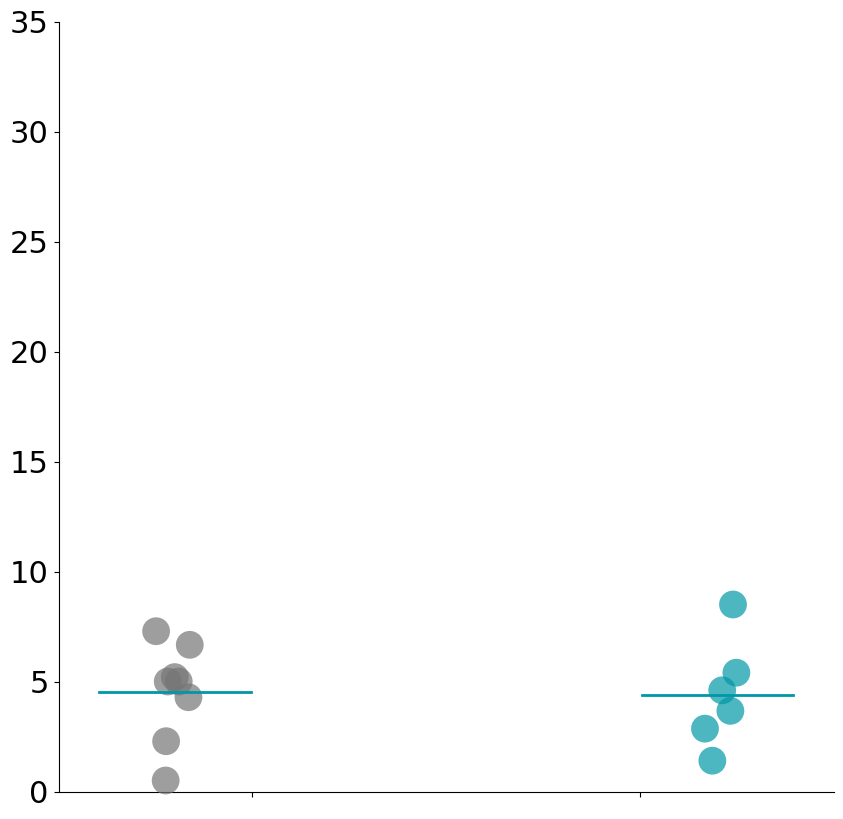

<Figure size 1000x1000 with 0 Axes>

In [17]:
#for SGN_contra_to_LMN_avg_counts (Figure 5A)
#get df with LMN fill
df = LMN_fill_df
#remove LMN_miss
df = df.loc[(~(df['LMN_group']=='LMN_miss'))]
#These brains are classified as miss since injection site is unclear
df = df.loc[(~(df['Brain']=='JG_84'))&(~(df['Brain']=='JG_92'))]
#group for color assignment
group = 'LMN_group'
#plot SGN label 

plt.figure()

stripplots('SGN_contra_to_LMN_avg_count',df,x_group='LMN_group',hue_group=group, dest_folder=cwd,pretty=True,ylabel='SGN_contra_to_LMN_avg_count',y_max=35)
       
              

python_analyses folder already exists!


<Figure size 1000x1000 with 0 Axes>

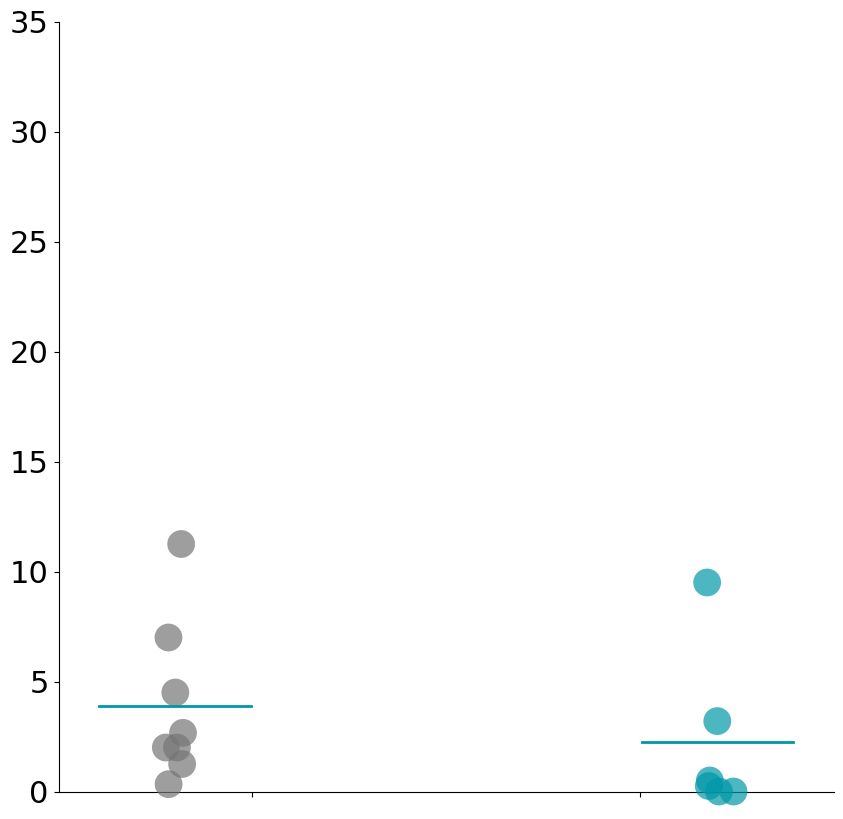

<Figure size 1000x1000 with 0 Axes>

In [18]:
#same as above but for SGN_ipsi and to_LMN (Figure 5C)
#for SGN_ipsi_to_LMN_avg_counts
#get df with LMN fill
df = injection_groups
#remove LMN_miss
df = df.loc[(~(df['LMN_group']=='LMN_miss'))]
#These brains should be classified as miss since injection site is unclear
df = df.loc[(~(df['Brain']=='JG_84'))&(~(df['Brain']=='JG_92'))]
#group for color assignment
group = 'LMN_group'
#plot SGN label 

plt.figure()

stripplots('SGN_ipsi_to_LMN_avg_count',df,x_group='LMN_group',hue_group=group, dest_folder=cwd,pretty=True,ylabel='SGN_ipsi_to_LMN_avg_count',y_max=35)
       
              

python_analyses folder already exists!


<Figure size 1000x1000 with 0 Axes>

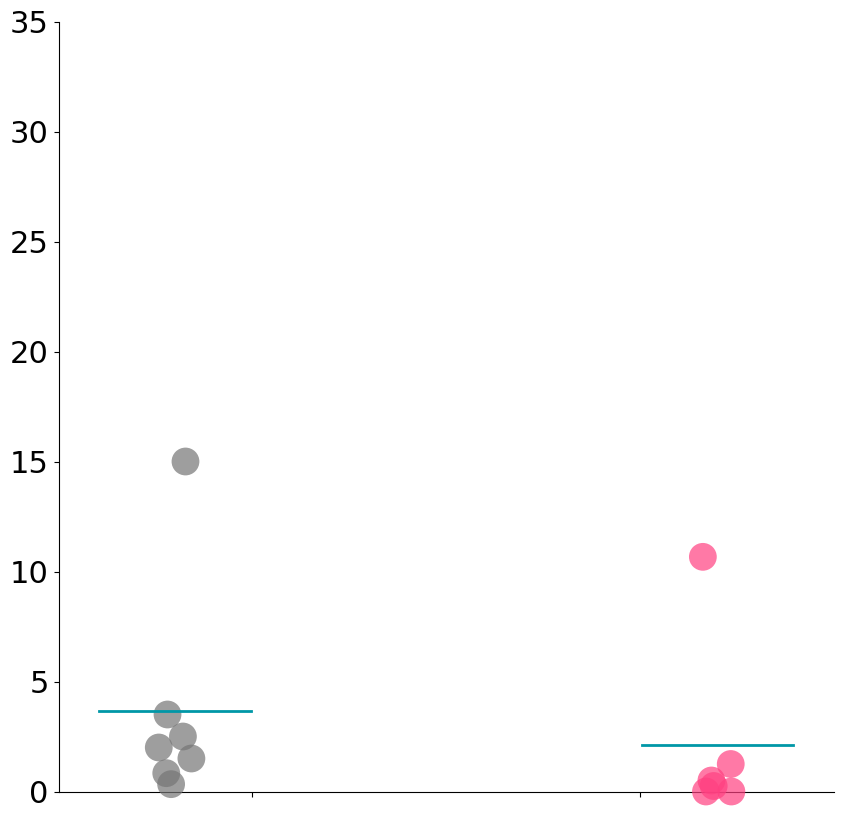

<Figure size 1000x1000 with 0 Axes>

In [19]:
#same as above but for SGN_ipsi to DTN (Figure 5D)

#get df with LMN fill
df = injection_groups
#remove LMN_miss
df = df.loc[(~(df['DTN_group']=='DTN_miss'))]
#These brains should be classified as miss since injection site is unclear
#df = df.loc[(~(df['Brain']=='JG_84'))&(~(df['Brain']=='JG_92'))]
#group for color assignment
group = 'DTN_group'
#plot SGN label 

plt.figure()

stripplots('SGN_ipsi_to_DTN_avg_count',df,x_group='DTN_group',hue_group=group, dest_folder=cwd,pretty=True,ylabel='SGN_ipsi_to_DTN_avg_count',y_max=35)
       
            

python_analyses folder already exists!


<Figure size 1000x1000 with 0 Axes>

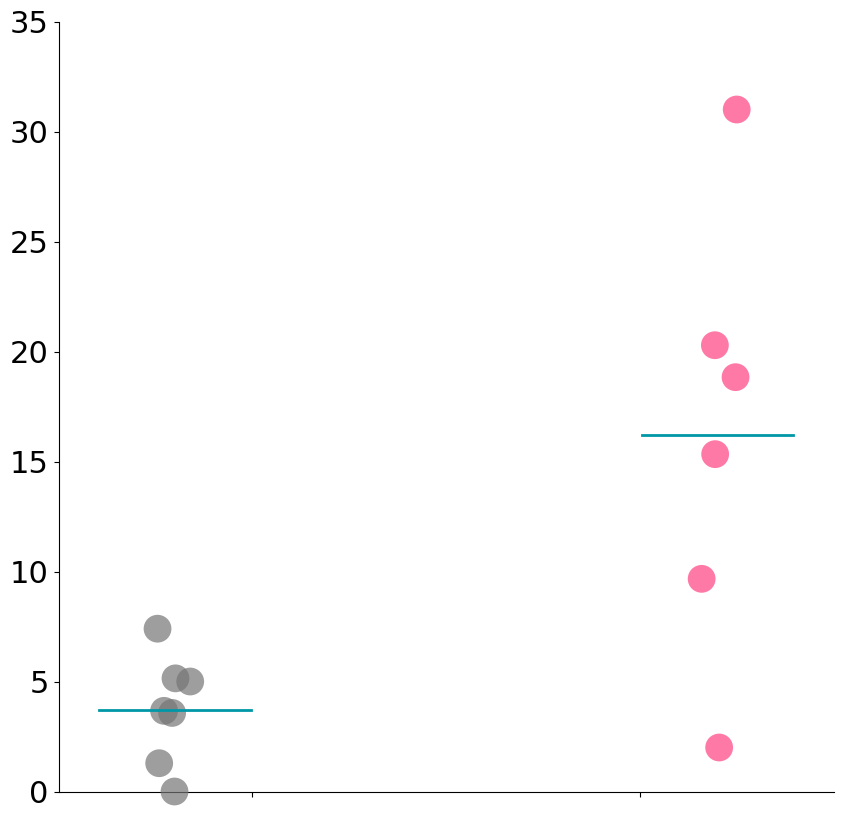

<Figure size 1000x1000 with 0 Axes>

In [20]:
#same as above but for SGN_contra to DTN avg counts (Figure 5B)

#get df with LMN fill
df = injection_groups
#remove LMN_miss
df = df.loc[(~(df['DTN_group']=='DTN_miss'))]
#These brains should be classified as miss since injection site is unclear
#df = df.loc[(~(df['Brain']=='JG_84'))&(~(df['Brain']=='JG_92'))]
#group for color assignment
group = 'DTN_group'
#plot SGN label 

plt.figure()

stripplots('SGN_contra_to_DTN_avg_count',df,x_group='DTN_group',hue_group=group, dest_folder=cwd,pretty=True,ylabel='SGN_contra_to_DTN_avg_count',y_max=35)
       
              

# Figure 4C

In [21]:
#just get a table with the three double hit animals and the proportions of DTN vs LMN populations (Figure 4C)
df = injection_groups
#just need double-hit
df = df.loc[(df['DTN_group']=='DTN_hit')&(df['LMN_group']=='LMN_hit')]
#columns
df[['Brain','SGN_contra_Double_label_avg_count','SGN_contra_avg_count_Double_label_percent_to_LMN','SGN_contra_avg_count_Double_label_percent_to_DTN']].to_csv('double_label_percent_of_SGN_contra_projection_pops.csv')
df[['Brain','SGN_contra_Double_label_avg_count','SGN_contra_avg_count_Double_label_percent_to_LMN','SGN_contra_avg_count_Double_label_percent_to_DTN']]

,Brain,SGN_contra_Double_label_avg_count,SGN_contra_avg_count_Double_label_percent_to_LMN,SGN_contra_avg_count_Double_label_percent_to_DTN
5,JG_85,2.857142,1.000000,0.140845
8,JG_89,3.333333,0.392157,0.344828
13,JG_94,0.200000,0.142857,0.006452


In [22]:
#same as above but for DTN double label (Contra DTN -->DTN)
df = injection_groups
df = df.loc[(df['DTN_group']=='DTN_hit')&(df['LMN_group']=='LMN_hit')]
df[['Brain','DTN_contra_Double_label_total_count','DTN_contra_Double_label_avg_count','DTN_contra_to_LMN_total_count','DTN_contra_to_LMN_avg_count','DTN_contra_to_DTN_total_count','DTN_contra_to_DTN_avg_count']]

,Brain,DTN_contra_Double_label_total_count,DTN_contra_Double_label_avg_count,DTN_contra_to_LMN_total_count,DTN_contra_to_LMN_avg_count,DTN_contra_to_DTN_total_count,DTN_contra_to_DTN_avg_count
5,JG_85,9.0,1.800000,132.0,26.399995,86.0,17.199997
8,JG_89,10.0,2.499999,21.0,5.249999,15.0,3.749999
13,JG_94,10.0,1.111111,65.0,7.222221,322.0,35.777774


## LMN fill correlation values
### Correlation values reported in text

In [23]:
#LMN_fill_df.to_csv('LMN_fill_df.csv')

In [24]:
#make some plots showing how LMN fill is related to contra_SGN label
df = LMN_fill_df
df.sort_values('avg_pct_LMN_fill')

,Brain,LMN_group,SGN_contra_to_LMN_avg_count,SGN_contra_to_LMN_total_count,num_LMN_slices_filled,avg_pct_LMN_fill,num_LMN_slices_mostly_filled_50,num_LMN_slices_mostly_filled_30,LMN surround amount,ctb_area_um_sqrd,ctb_area_mm_sqrd,LMN_ctb_area_um_sqrd,LMN_ctb_area_mm_sqrd
4,JG_88,LMN_miss,4.666666,28.0,0,0.00,0,0,NaN,NaN,NaN,NaN,NaN
14,JG_95,LMN_adjacent,4.999998,15.0,0,0.00,0,0,NaN,156585.0,0.16,0.0,0.00
3,JG_84,LMN_adjacent,0.000000,0.0,0,0.00,0,0,small,NaN,NaN,NaN,NaN
12,JG_93,LMN_adjacent,7.285713,51.0,4,0.00,0,0,NaN,318641.0,0.32,671.0,0.00
11,JG_92,LMN_adjacent,2.000000,12.0,0,0.00,0,0,small,NaN,NaN,NaN,NaN
15,JG_96,LMN_adjacent,5.199999,26.0,0,0.00,0,0,large,378498.0,0.38,0.0,0.00
7,JG_87,LMN_adjacent,6.666666,40.0,2,0.01,0,0,small,72507.0,0.07,3712.0,0.00
9,JG_90,LMN_adjacent,0.500000,3.0,2,0.02,0,0,small,37857.0,0.04,4575.0,0.00
6,JG_86,LMN_adjacent,4.285714,30.0,4,0.08,0,0,medium,347723.0,0.35,31080.0,0.03
16,JG_97,LMN_adjacent,4.999999,25.0,1,0.12,0,0,medium,28527.0,0.03,11797.0,0.01


,n,r,CI95%,p-val,BF10,power
pearson,17,0.171911,"[-0.34, 0.6]",0.509409,0.367,0.101413


C:\Users\F004b3k\AppData\Local\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


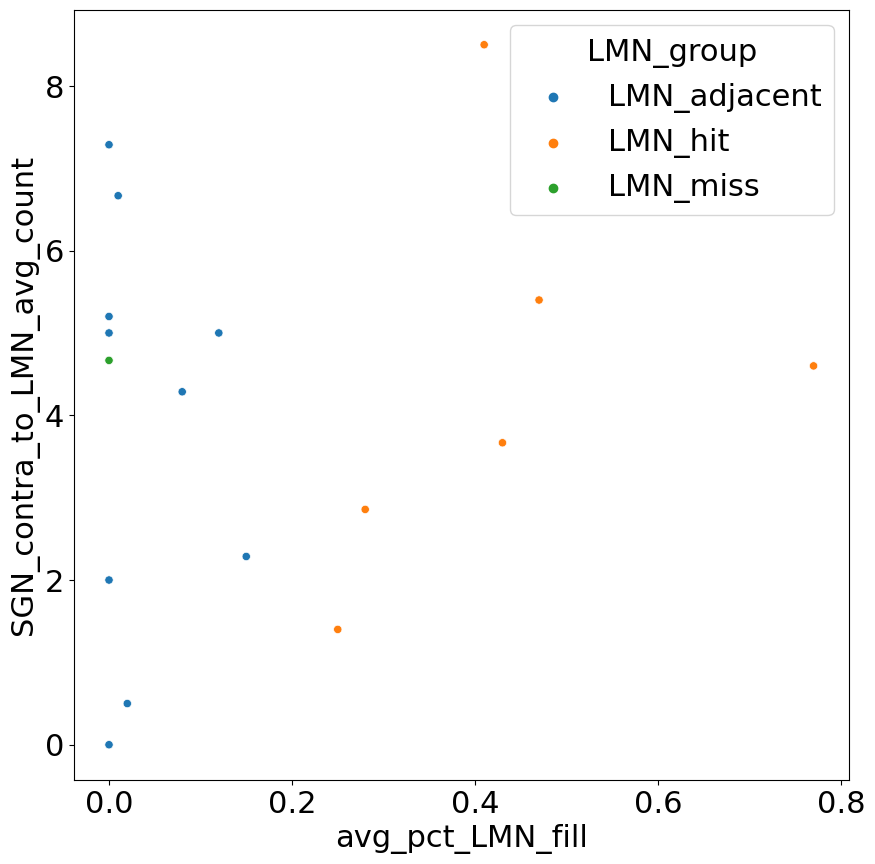

In [25]:
#plot avg_pct fill vs avg and total count
df = LMN_fill_df
ax = sns.scatterplot(x=df['avg_pct_LMN_fill'],y = df['SGN_contra_to_LMN_avg_count'], hue = df['LMN_group'])
#get a pearson_r? #possibly need to exclude values at 0
#df = df.loc[df['avg_pct_LMN_fill']>0.2]
import pingouin as pg
pg.corr(x=df['avg_pct_LMN_fill'],y = df['SGN_contra_to_LMN_avg_count'])

,n,r,CI95%,p-val,BF10,power
pearson,17,0.012564,"[-0.47, 0.49]",0.961828,0.3,0.049418


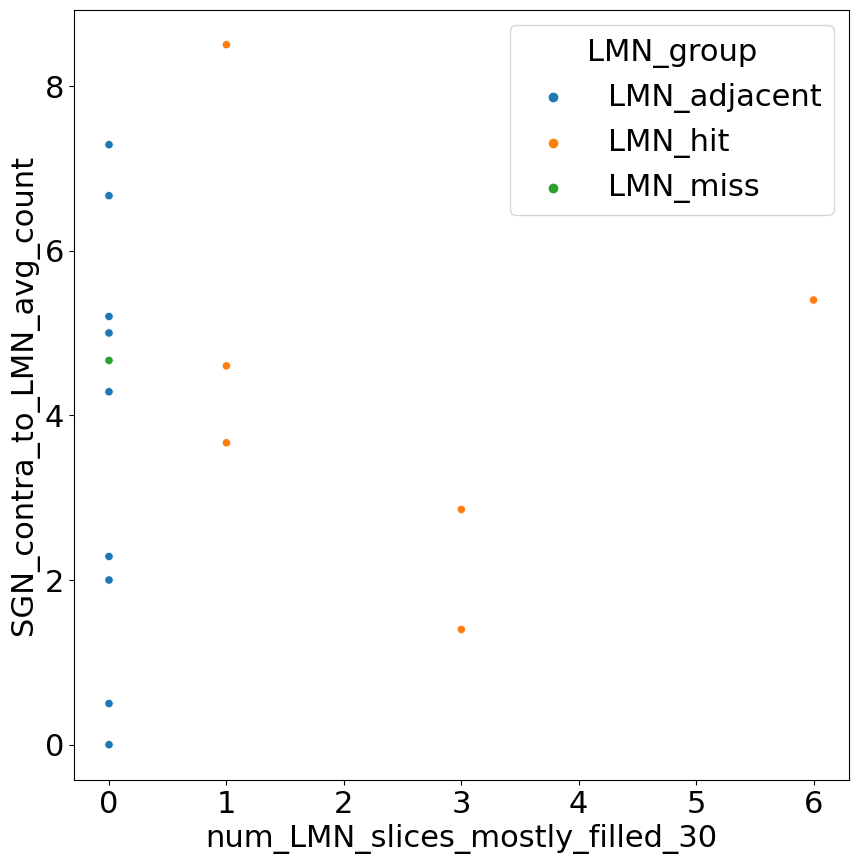

In [26]:
#same as above but with number of slices filled more than 30
#plot avg_pct fill vs avg and total count
df = LMN_fill_df
ax = sns.scatterplot(x=df['num_LMN_slices_mostly_filled_30'],y = df['SGN_contra_to_LMN_avg_count'], hue = df['LMN_group'])
#get a pearson_r? #possibly need to exclude values at 0
#df = df.loc[df['avg_pct_LMN_fill']>0.2]
import pingouin as pg
pg.corr(x=df['num_LMN_slices_mostly_filled_30'],y = df['SGN_contra_to_LMN_avg_count'])

In [27]:
#plot num_LMN_slices_mostly_filled_30 vs avg and total count

In [28]:
df = LMN_fill_df
df.columns

Index(['Brain', 'LMN_group', 'SGN_contra_to_LMN_avg_count',
       'SGN_contra_to_LMN_total_count', 'num_LMN_slices_filled',
       'avg_pct_LMN_fill', 'num_LMN_slices_mostly_filled_50',
       'num_LMN_slices_mostly_filled_30', 'LMN surround amount',
       'ctb_area_um_sqrd', 'ctb_area_mm_sqrd', 'LMN_ctb_area_um_sqrd',
       'LMN_ctb_area_mm_sqrd'],
      dtype='object')

In [29]:
df.loc[df['LMN_group']=='LMN_adjacent'].sort_values('avg_pct_LMN_fill')

,Brain,LMN_group,SGN_contra_to_LMN_avg_count,SGN_contra_to_LMN_total_count,num_LMN_slices_filled,avg_pct_LMN_fill,num_LMN_slices_mostly_filled_50,num_LMN_slices_mostly_filled_30,LMN surround amount,ctb_area_um_sqrd,ctb_area_mm_sqrd,LMN_ctb_area_um_sqrd,LMN_ctb_area_mm_sqrd
14,JG_95,LMN_adjacent,4.999998,15.0,0,0.00,0,0,NaN,156585.0,0.16,0.0,0.00
3,JG_84,LMN_adjacent,0.000000,0.0,0,0.00,0,0,small,NaN,NaN,NaN,NaN
12,JG_93,LMN_adjacent,7.285713,51.0,4,0.00,0,0,NaN,318641.0,0.32,671.0,0.00
11,JG_92,LMN_adjacent,2.000000,12.0,0,0.00,0,0,small,NaN,NaN,NaN,NaN
15,JG_96,LMN_adjacent,5.199999,26.0,0,0.00,0,0,large,378498.0,0.38,0.0,0.00
7,JG_87,LMN_adjacent,6.666666,40.0,2,0.01,0,0,small,72507.0,0.07,3712.0,0.00
9,JG_90,LMN_adjacent,0.500000,3.0,2,0.02,0,0,small,37857.0,0.04,4575.0,0.00
6,JG_86,LMN_adjacent,4.285714,30.0,4,0.08,0,0,medium,347723.0,0.35,31080.0,0.03
16,JG_97,LMN_adjacent,4.999999,25.0,1,0.12,0,0,medium,28527.0,0.03,11797.0,0.01
10,JG_91,LMN_adjacent,2.285714,16.0,3,0.15,0,0,small,274143.0,0.27,52191.0,0.05


## Compare SGN counts in animals with injections that hit LMN and also spread to adjacent tissue to animals with injections to LMN that only hit adjacent tissue (Figure 7 B, D)

python_analyses folder already exists!


<Figure size 1000x1000 with 0 Axes>

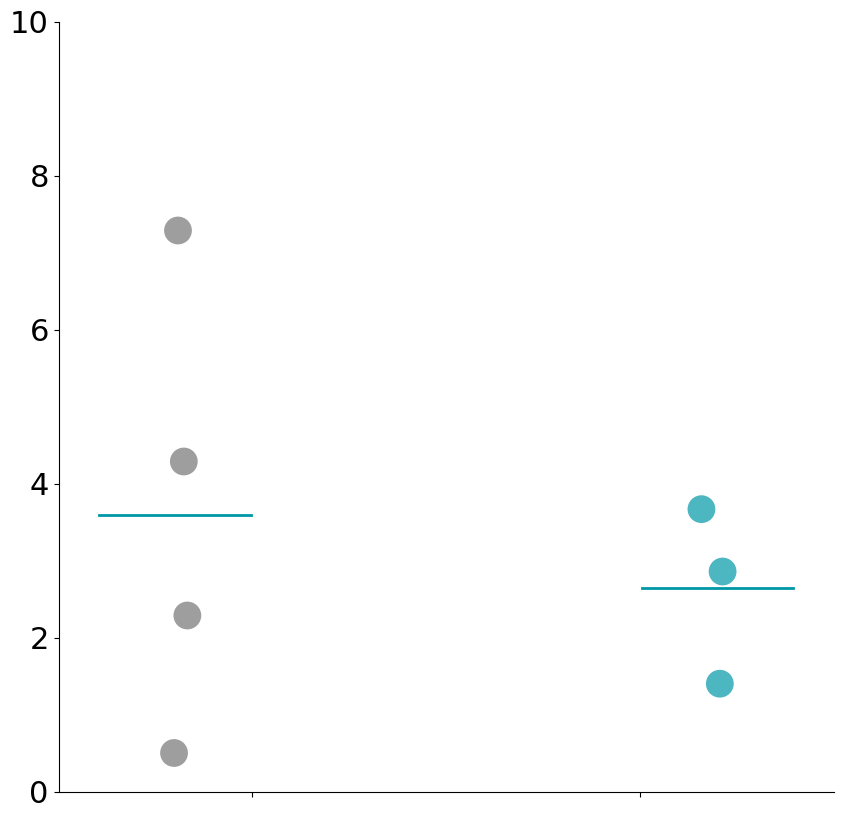

<Figure size 1000x1000 with 0 Axes>

In [30]:
#instructive examples of LMN hit and adjacent comparison for superficial tissue (Figure 7B)
sup_hit = ['JG_94','JG_85','JG_65']
sup_adj = ['JG_86','JG_91','JG_93','JG_90']
#get df with correct brains
df = LMN_fill_df
df = df.loc[(df['Brain'].isin(sup_hit))|(df['Brain'].isin(sup_adj))]
group = 'LMN_group'
#plot SGN label 

plt.figure()

stripplots('SGN_contra_to_LMN_avg_count',df,x_group='LMN_group',hue_group=group, dest_folder=cwd,pretty=True,ylabel='above_LMN_SGN_avg_count',y_max=10)
       
                                
                                    


python_analyses folder already exists!


<Figure size 1000x1000 with 0 Axes>

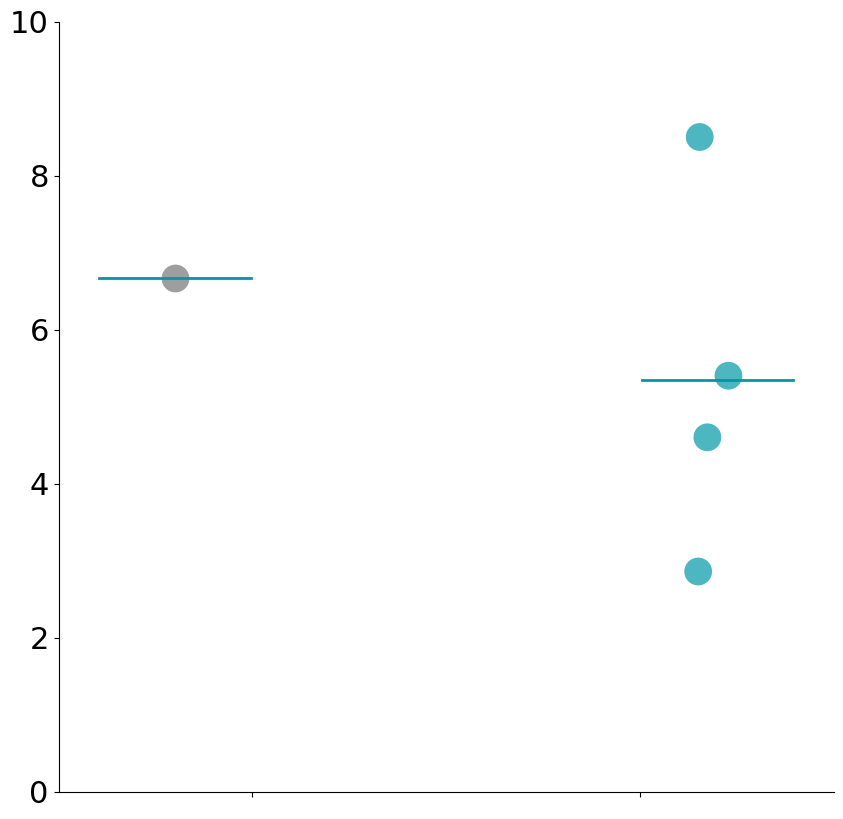

<Figure size 1000x1000 with 0 Axes>

In [31]:
#instructive examples of LMN hit and adjacent comparison for superficial tissue (Figure 7D)
med_hit = ['JG_85','JG_89','JG_55','JG_61']
med_adj = ['JG_87']
#get df with correct brains
df = LMN_fill_df
df = df.loc[(df['Brain'].isin(med_hit))|(df['Brain'].isin(med_adj))]
group = 'LMN_group'
#plot SGN label 

plt.figure()

stripplots('SGN_contra_to_LMN_avg_count',df,x_group='LMN_group',hue_group=group, dest_folder=cwd,pretty=True,ylabel='med_to_LMN_SGN_avg_count',y_max=10)
       
                                
                     


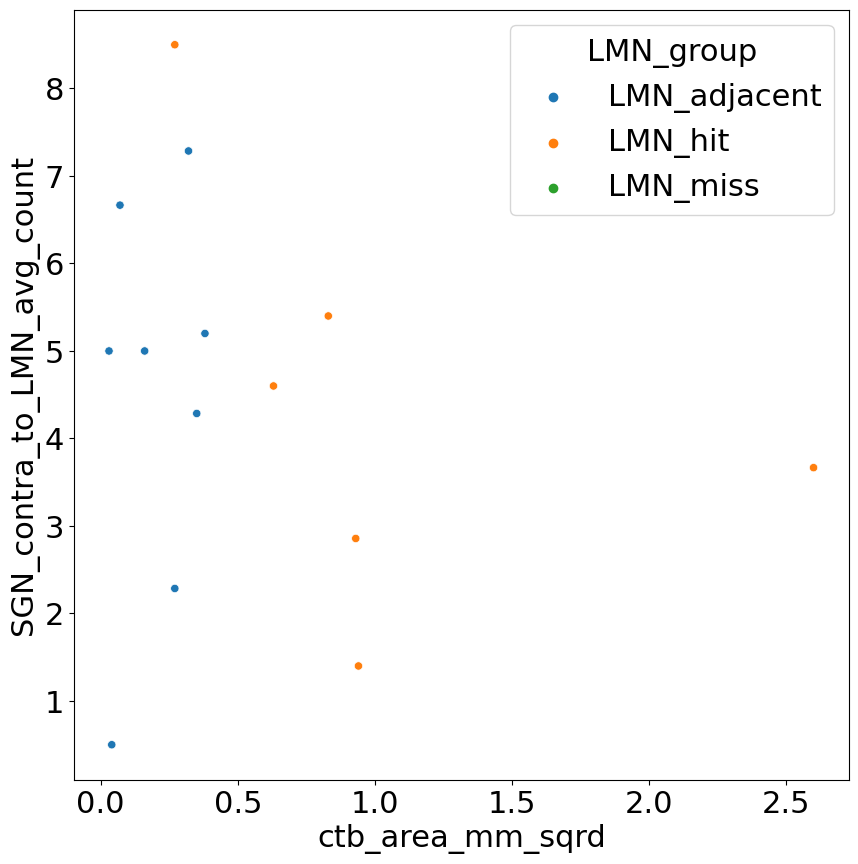

In [32]:
#scatter graphs for LMN with total tracer amount vs SGN_contra label (graphs are unused but correlation values are reported)

#plot avg_pct fill vs avg and total count
df = LMN_fill_df
ax = sns.scatterplot(x=df['ctb_area_mm_sqrd'],y = df['SGN_contra_to_LMN_avg_count'], hue = df['LMN_group'])
#get a pearson_r? #possibly need to exclude values at 0
#df = df.loc[df['avg_pct_LMN_fill']>0.2]

#pg.corr(x=df['num_LMN_slices_mostly_filled_30'],y = df['SGN_contra_to_LMN_avg_count'])

         n         r         CI95%     p-val   BF10     power
pearson  6 -0.251155  [-0.88, 0.7]  0.631189  0.543  0.077827


,Brain,LMN_group,SGN_contra_to_LMN_avg_count,SGN_contra_to_LMN_total_count,num_LMN_slices_filled,avg_pct_LMN_fill,num_LMN_slices_mostly_filled_50,num_LMN_slices_mostly_filled_30,LMN surround amount,ctb_area_um_sqrd,ctb_area_mm_sqrd,LMN_ctb_area_um_sqrd,LMN_ctb_area_mm_sqrd
13,JG_94,LMN_hit,1.400000,7.0,5,0.25,1,3,moderate,944546.0,0.94,185855.0,0.19
5,JG_85,LMN_hit,2.857142,20.0,5,0.28,2,3,small,928364.0,0.93,155363.0,0.16
2,JG_65,LMN_hit,3.666665,11.0,2,0.43,1,1,large,2596577.0,2.60,532701.0,0.53
1,JG_61,LMN_hit,4.599999,23.0,1,0.77,1,1,small,630605.0,0.63,56841.0,0.06
0,JG_55,LMN_hit,5.399999,27.0,7,0.47,5,6,medium,830875.0,0.83,302037.0,0.30
8,JG_89,LMN_hit,8.499999,51.0,2,0.41,1,1,small,273814.0,0.27,87202.0,0.09


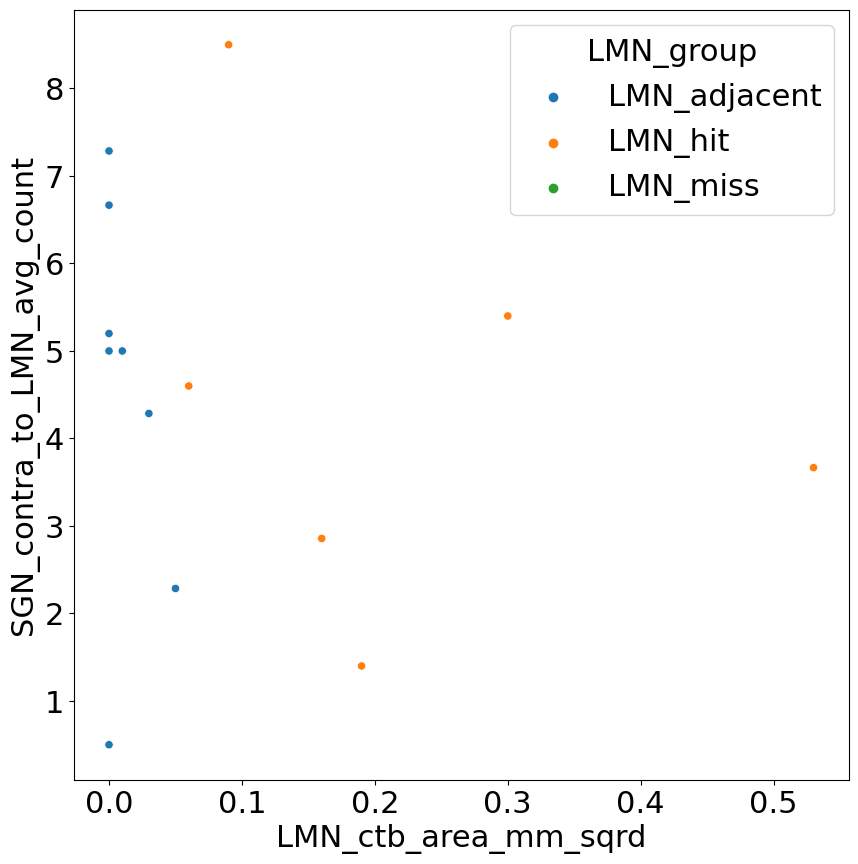

In [33]:
#same as above but for total area of ctb in LMN
#scatter graphs for LMN with total tracer amount vs SGN_contra label

#plot avg_pct fill vs avg and total count
df = LMN_fill_df
ax = sns.scatterplot(x=df['LMN_ctb_area_mm_sqrd'],y = df['SGN_contra_to_LMN_avg_count'], hue = df['LMN_group'])
#get a pearson_r? #possibly need to exclude values at 0
#df = df.loc[df['avg_pct_LMN_fill']>0.2]
#only makes sense to look at LMN hit as adjacent could have large amounts of tissue filled with ctb outside of LMN.  
df = df.loc[df['LMN_group']=='LMN_hit']
print(pg.corr(x=df['LMN_ctb_area_mm_sqrd'],y = df['SGN_contra_to_LMN_avg_count']))
df.loc[df['LMN_group']=='LMN_hit'].sort_values('SGN_contra_to_LMN_avg_count')

In [34]:
#want to see whether there is a trend for increased area to increased sgn label within fluorophore



,n,r,CI95%,p-val,BF10,power
pearson,14,-0.212068,"[-0.67, 0.36]",0.466705,0.419,0.113242


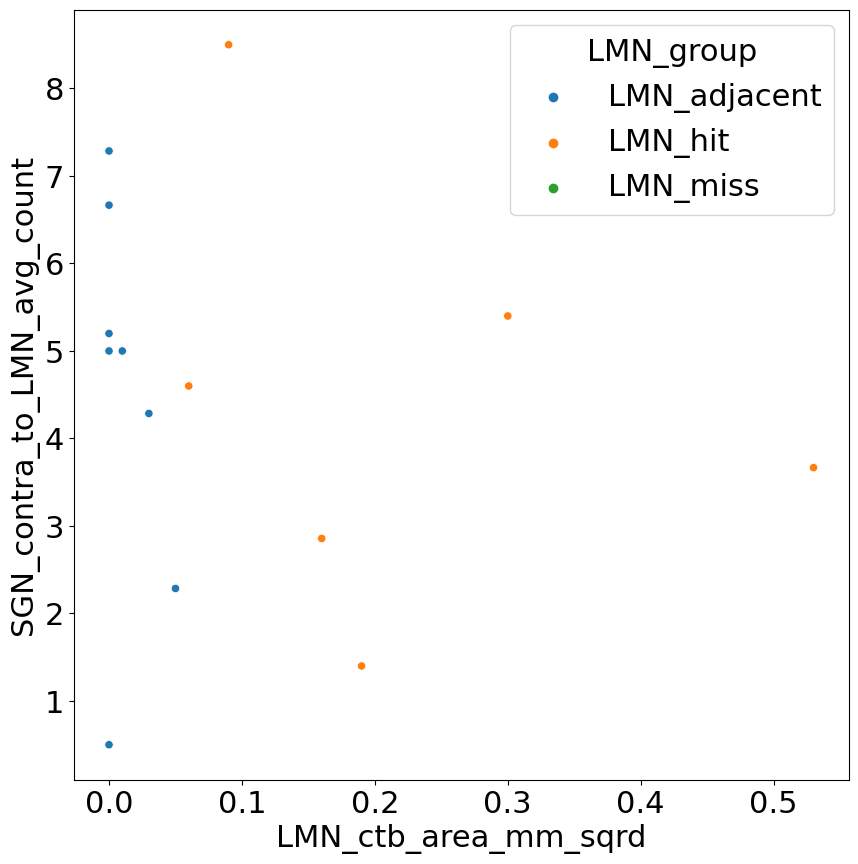

In [35]:
#same as above but plotting ctb area outside of LMN
#add a new column - total area of ctb outside of LMN
df = LMN_fill_df
df['total_area_outside_LMN_mm'] = df['ctb_area_mm_sqrd'] - df['LMN_ctb_area_mm_sqrd']
#plot avg_pct fill vs avg and total count
df = LMN_fill_df
ax = sns.scatterplot(x=df['LMN_ctb_area_mm_sqrd'],y = df['SGN_contra_to_LMN_avg_count'], hue = df['LMN_group'])
pg.corr(x=df['total_area_outside_LMN_mm'],y = df['SGN_contra_to_LMN_avg_count'])

In [36]:
# describe DTN_contra_double label counts
df = injection_groups
#exclude brains with Nan values in DTN_group or LMN_miss or DTN_miss (JG_84)
df = df.loc[(~(df['DTN_group'].isnull()==True))&(~(df['Brain']=='JG_84'))]
df[['Brain','DTN_group','LMN_group','DTN_contra_Double_label_avg_count']]


df[['DTN_contra_Double_label_avg_count']].describe()
#avg to_DTN or to_LMN avg counts alone
df['DTN_contra_to_DTN_avg_count'].describe()

count    13.000000
mean      9.811720
std      10.121854
min       0.000000
25%       3.749999
50%       6.749999
75%      11.142856
max      35.777774
Name: DTN_contra_to_DTN_avg_count, dtype: float64

In [37]:
#just need single-label counts for my double-hit animals
df = injection_groups
df.columns

df[['Brain','SGN_contra_to_DTN_avg_count', 'SGN_contra_to_LMN_avg_count','SGN_contra_to_DTN_total_count','SGN_contra_to_LMN_total_count','SGN_contra_Double_label_avg_count']]

,Brain,SGN_contra_to_DTN_avg_count,SGN_contra_to_LMN_avg_count,SGN_contra_to_DTN_total_count,SGN_contra_to_LMN_total_count,SGN_contra_Double_label_avg_count
0,JG_55,0.000000,5.399999,0.0,27.0,0.000000
1,JG_61,0.000000,4.599999,0.0,23.0,0.000000
2,JG_65,0.000000,3.666665,0.0,11.0,0.000000
3,JG_84,0.000000,0.000000,0.0,0.0,0.000000
4,JG_88,18.833330,4.666666,113.0,28.0,1.333333
5,JG_85,20.285711,2.857142,142.0,20.0,2.857142
6,JG_86,3.571428,4.285714,25.0,30.0,3.000000
7,JG_87,8.999999,6.666666,54.0,40.0,3.333333
8,JG_89,9.666665,8.499999,58.0,51.0,3.333333
9,JG_90,15.333331,0.500000,92.0,3.0,0.500000


In [38]:
#get only DTN-DTN cells and describe average counts just to see what the range is like
df = injection_groups
df = df.loc[df['DTN_group']=='DTN_hit']
df[['Brain','DTN_group','DTN_contra_to_DTN_total_count','DTN_contra_to_DTN_avg_count','DTN_contra_Double_label_avg_count']].describe()


,DTN_contra_to_DTN_total_count,DTN_contra_to_DTN_avg_count,DTN_contra_Double_label_avg_count
count,6.000000,6.000000,6.000000
mean,112.500000,14.961770,2.087566
std,116.342168,13.089372,0.799775
min,15.000000,2.571428,1.111111
25%,30.750000,4.537499,1.628571
50%,77.500000,12.049998,1.971428
75%,145.250000,21.978568,2.410714
max,322.000000,35.777774,3.400000


In [39]:
#same as above but for DTN-LMN
df = injection_groups
df = df.loc[df['LMN_group']=='LMN_hit']
df[['Brain','LMN_group','DTN_contra_to_LMN_total_count','DTN_contra_to_LMN_avg_count','DTN_contra_Double_label_avg_count']].describe()


,DTN_contra_to_LMN_total_count,DTN_contra_to_LMN_avg_count,DTN_contra_Double_label_avg_count
count,6.000000,6.000000,6.000000
mean,89.166667,25.228695,0.901852
std,40.799101,17.029425,1.081161
min,21.000000,5.249999,0.000000
25%,72.000000,12.016665,0.000000
50%,97.500000,28.449994,0.555555
75%,117.000000,30.874990,1.627777
max,132.000000,50.999975,2.499999


In [40]:
#same as above but only double hit animals so we can get the correct double_label numbers
df = injection_groups
df = df.loc[(df['DTN_group']=='DTN_hit')&(df['LMN_group']=='LMN_hit')]
df[['Brain','DTN_group','DTN_contra_to_DTN_total_count','DTN_contra_to_DTN_avg_count','DTN_contra_Double_label_avg_count']].describe()


,DTN_contra_to_DTN_total_count,DTN_contra_to_DTN_avg_count,DTN_contra_Double_label_avg_count
count,3.000000,3.000000,3.000000
mean,141.000000,18.909256,1.803703
std,160.720254,16.082157,0.694452
min,15.000000,3.749999,1.111111
25%,50.500000,10.474998,1.455555
50%,86.000000,17.199997,1.800000
75%,204.000000,26.488885,2.150000
max,322.000000,35.777774,2.499999
